#Installing and Importing libraries

Need mount your Google Drive folder, make sure you change the directory to the one where you paste the entire repository

In [17]:
import os
from google.colab import drive
drive.mount('/content/mydir')
os.chdir('/content/mydir/MyDrive/Xiaohan/GQME_tutorial_tt-tfd')

Drive already mounted at /content/mydir; to attempt to forcibly remount, call drive.mount("/content/mydir", force_remount=True).


In [2]:
import numpy as np
import time

#parameters in the simulation
from params import *
#read and write functions
import readwrite as wr

import matplotlib.pyplot as plt

SPIN-BOSON Model parameter
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
     time steps = 2000
             DT = 0.0015008299950527925
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 60


#Using TT-TFD to simulate Spin-Boson Model Dynamics

The tensor-train library, ttpy, is available at https://github.com/oseledets/ttpy and must be on your computer before doing the TT-TFD.

In [ ]:
#!pip install git+https://github.com/bcallen95/ttpy.git
!pip install git+https://github.com/oseledets/ttpy.git

In [ ]:
import tt_tfd as tfd

#RDO: reduced density operator, contain the information of population and coherence
#initial_state=0: initial at Donor state
t, RDO_arr = tfd.tt_tfd(initial_state=0)

#TT-TFD is time consuming, after running it once, you can read it from the file without running it again
#output to the file
wr.output_operator_array(t, RDO_arr, "TTTFD_Output/TFDSigma_")

This is a 121-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=1, n(1)=10 
r(2)=1, n(2)=10 
r(3)=1, n(3)=10 
r(4)=1, n(4)=10 
r(5)=1, n(5)=10 
r(6)=1, n(6)=10 
r(7)=1, n(7)=10 
r(8)=1, n(8)=10 
r(9)=1, n(9)=10 
r(10)=1, n(10)=10 
r(11)=1, n(11)=10 
r(12)=1, n(12)=10 
r(13)=1, n(13)=10 
r(14)=1, n(14)=10 
r(15)=1, n(15)=10 
r(16)=1, n(16)=10 
r(17)=1, n(17)=10 
r(18)=1, n(18)=10 
r(19)=1, n(19)=10 
r(20)=1, n(20)=10 
r(21)=1, n(21)=10 
r(22)=1, n(22)=10 
r(23)=1, n(23)=10 
r(24)=1, n(24)=10 
r(25)=1, n(25)=10 
r(26)=1, n(26)=10 
r(27)=1, n(27)=10 
r(28)=1, n(28)=10 
r(29)=1, n(29)=10 
r(30)=1, n(30)=10 
r(31)=1, n(31)=10 
r(32)=1, n(32)=10 
r(33)=1, n(33)=10 
r(34)=1, n(34)=10 
r(35)=1, n(35)=10 
r(36)=1, n(36)=10 
r(37)=1, n(37)=10 
r(38)=1, n(38)=10 
r(39)=1, n(39)=10 
r(40)=1, n(40)=10 
r(41)=1, n(41)=10 
r(42)=1, n(42)=10 
r(43)=1, n(43)=10 
r(44)=1, n(44)=10 
r(45)=1, n(45)=10 
r(46)=1, n(46)=10 
r(47)=1, n(47)=10 
r(48)=1, n(48)=10 
r(49)=1, n(49)=10 
r(50)=1, n(50)=10 
r(51)=1, n(51)=10 

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


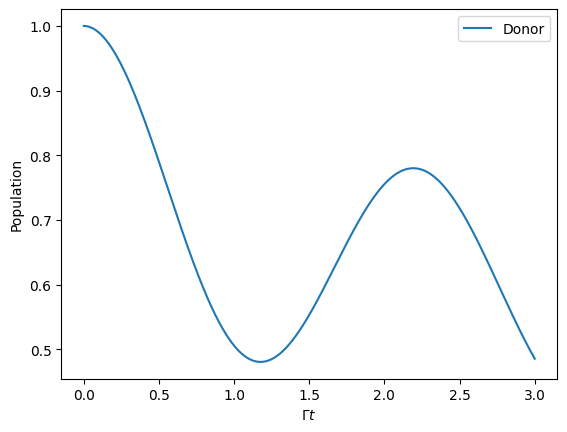

In [ ]:
#read and plot
t, RDO_arr = wr.read_operator_array("tttfd_reference_Sigma")
plt.plot(t, RDO_arr[:,0], label='Donor')
plt.xlabel('$\Gamma t$')
plt.ylabel('Population')
plt.legend()

#Using GQME to simulate Spin-Boson Model dynamics

##The projected Liouvillian

In [3]:
LN0 = np.zeros((DOF_E_SQ, DOF_E_SQ))
LN0[0][1] = LN0[1][0] = LN0[2][3] = LN0[3][2] = -GAMMA_DA
LN0[0][2] = LN0[2][0] = LN0[1][3] = LN0[3][1] = GAMMA_DA
LN0[1][1] = 2. * EPSILON
LN0[2][2] = -2. * EPSILON

## Calculating the Memory Kernel

### The Projection-Free Inputs

In [ ]:
def cal_U_tt_tfd():

    U = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

    # tt-tfd with initial state 0,1,2,3
    # initial state |0> means donor state |D>, |3> means acceptor state |A>
    # |1> is (|D> + |A>)/sqrt(2), |2> is (|D> + i|A>)/sqrt(2)
    t,U[:,:,0] = tfd.tt_tfd(0)
    t,U[:,:,1] = tfd.tt_tfd(1)
    t,U[:,:,2] = tfd.tt_tfd(2)
    t,U[:,:,3] = tfd.tt_tfd(3)

    U_final = U.copy()

    # the coherence elements that start at initial state |D><A| and |A><D|
    # is the linear combination of above U results
    # |D><A| = |1><1| + i * |2><2| - 1/2 * (1 + i) * (|0><0| + |3><3|)
    U_final[:,:,1] = U[:,:,1] + 1.j * U[:,:,2] - 0.5 * (1. + 1.j) * (U[:,:,0] + U[:,:,3])

    # |A><D| = |1><1| - i * |2><2| - 1/2 * (1 - i) * (|0><0| + |3><3|)
    U_final[:,:,2] = U[:,:,1] - 1.j * U[:,:,2] - 0.5 * (1. - 1.j) * (U[:,:,0] + U[:,:,3])

    #output U
    wr.output_superoper_array(t,U_final,"U_Output/U_")

    return 0

In [ ]:
#this is time consuming, after running it once, you can read it from the file without running it again
cal_U_tt_tfd()

In [5]:
def cal_F():
    #read the propagator data from files
    timeVec,U = wr.read_superoper_array("U_Output/U_")

    F = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
    Fdot = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

    for j in range(DOF_E_SQ):
        for k in range(DOF_E_SQ):
            # extracts real and imag parts of U element
            Ureal = U[:,j,k].copy().real
            Uimag = U[:,j,k].copy().imag

            # F = i * d/dt U so Re[F] = -1 * d/dt Im[U] and Im[F] = d/dt Re[U]
            Freal = -1. * np.gradient(Uimag.flatten(), DT, edge_order = 2)
            Fimag = np.gradient(Ureal.flatten(), DT, edge_order = 2)

            # Fdot = d/dt F so Re[Fdot] = d/dt Re[F] and Im[Fdot] = d/dt Im[F]
            Fdotreal = np.gradient(Freal, DT)
            Fdotimag = np.gradient(Fimag, DT)

            F[:,j,k] = Freal[:] + 1.j * Fimag[:]
            Fdot[:,j,k] = Fdotreal[:] + 1.j * Fdotimag[:]

    #write the result to the file
    wr.output_superoper_array(timeVec,F,"ProjFree_Output/F_")
    wr.output_superoper_array(timeVec,Fdot,"ProjFree_Output/Fdot_")

    return timeVec,F,Fdot

In [6]:
timeVec,F,Fdot = cal_F()

###volterra scheme: calculating the Memory kernel and output to the file

In [7]:
linearTerm = 1.j * Fdot.copy() # first term of the linear part
for l in range(TIME_STEPS):
    # subtracts second term of linear part
    linearTerm[l,:,:] -= 1./HBAR * F[l,:,:] @ LN0

In [8]:
def CalculateIntegral(DOF_E_SQ, F, linearTerm, prevKernel, kernel):

    # time step loop starts at 1 because K is equal to linear part at t = 0
    for n in range(1, TIME_STEPS):
        kernel[n,:,:] = 0.

        # f(a) and f(b) terms
        kernel[n,:,:] += 0.5 * DT * F[n,:,:] @ kernel[0,:,:]
        kernel[n,:,:] += 0.5 * DT * F[0,:,:] @ prevKernel[n,:,:]

        # sum of f(a + kh) term
        for c in range(1, n):
            # since a new (supposed-to-be-better) guess for the
            # kernel has been calculated for previous time steps,
            # can use it rather than prevKernel
            kernel[n,:,:] += DT * F[n - c,:,:] @ kernel[c,:,:]

        # multiplies by i and adds the linear part
        kernel[n,:,:] = 1.j * kernel[n,:,:] + linearTerm[n,:,:]

    return kernel

In [9]:
START_TIME = time.time() # starts timing
# sets initial guess to the linear part
prevKernel = linearTerm.copy()
kernel = linearTerm.copy()

# loop for iterations
for numIter in range(1, MAX_ITERS + 1):

    iterStartTime = time.time() # starts timing of iteration
    print("Iteration:", numIter)

    # calculates kernel using prevKernel and trapezoidal rule
    kernel = CalculateIntegral(DOF_E_SQ, F, linearTerm, prevKernel, kernel)

    numConv = 0 # parameter used to check convergence of entire kernel
    for i in range(DOF_E_SQ):
        for j in range(DOF_E_SQ):
            for n in range(TIME_STEPS):
                # if matrix element and time step of kernel is converged, adds 1
                if abs(kernel[n][i][j] - prevKernel[n][i][j]) <= CONVERGENCE_PARAM:
                    numConv += 1

                # if at max iters, prints which elements and time steps did not
                # converge and prevKernel and kernel values
                elif numIter == MAX_ITERS:
                    print("\tK time step and matrix element that didn't converge: %s, %s%s"%(n,i,j))

    print("\tIteration time:", time.time() - iterStartTime)

    # enters if all times steps and matrix elements of kernel converged
    if numConv == TIME_STEPS * DOF_E_SQ * DOF_E_SQ:
        # prints number of iterations and time necessary for convergence
        print("Number of Iterations:", numIter, "\tVolterra time:", time.time() - START_TIME)

        # prints memory kernel to files
        wr.output_superoper_array(timeVec,kernel,"K_Output/K_")

        break # exits the iteration loop

    # if not converged, stores kernel as prevKernel, zeros the kernel, and then
    # sets kernel at t = 0 to linear part
    prevKernel = kernel.copy()
    kernel = linearTerm.copy()

    # if max iters reached, prints lack of convergence
    if numIter == MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%MAX_ITERS)
        print("\tVolterra time:", print(time.time() - START_TIME))

Iteration: 1


KeyboardInterrupt: 

##Propagate the GQME

In [10]:
def PropagateRK4(currentTime, memTime, kernel,
                 sigma_hold, sigma):

    f_0 = Calculatef(currentTime, memTime,
                     kernel, sigma, sigma_hold)

    k_1 = sigma_hold + DT * f_0 / 2.
    f_1 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_1)

    k_2 = sigma_hold + DT * f_1 /2.
    f_2 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_2)

    k_3 = sigma_hold + DT * f_2
    f_3 = Calculatef(currentTime + DT, memTime,
                     kernel, sigma, k_3)

    sigma_hold += DT / 6. * (f_0 + 2. * f_1 + 2. * f_2 + f_3)

    return sigma_hold


In [11]:
def Calculatef(currentTime, memTime, kernel, sigma_array, kVec):
    global LN0, HBAR

    memTimeSteps = int(memTime / DT)
    currentTimeStep = int(currentTime / DT)

    f_t = np.zeros(kVec.shape, dtype=np.complex_)

    f_t -= 1.j / HBAR * LN0 @ kVec

    limit = memTimeSteps
    if currentTimeStep < (memTimeSteps - 1):
        limit = currentTimeStep
    for l in range(limit):
        f_t -= DT * kernel[l,:,:] @ sigma_array[currentTimeStep - l]

    return f_t


In [12]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array("K_Output/K_")

# array for reduced density matrix elements
sigma = np.zeros((TIME_STEPS, DOF_E_SQ), dtype=np.complex_)
# array to hold copy of sigma
sigma_hold = np.zeros(DOF_E_SQ, dtype = np.complex_)

# sets the initial state at Donor State
sigma[0,0] = 1.
sigma_hold[0] = 1.

# loop to propagate sigma
print(">>> Starting GQME propagation, memory time =", MEM_TIME)
for l in range(TIME_STEPS - 1): # it propagates to the final time step
    print(l)
    currentTime = l * DT

    sigma_hold = PropagateRK4(currentTime, MEM_TIME, kernel, sigma_hold, sigma)

    sigma[l + 1] = sigma_hold.copy()

# prints sigma to files
wr.output_operator_array(timeVec, sigma, "GQME_Output/Sigma_")

>>> Starting GQME propagation, memory time = 3.001659990105585
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261

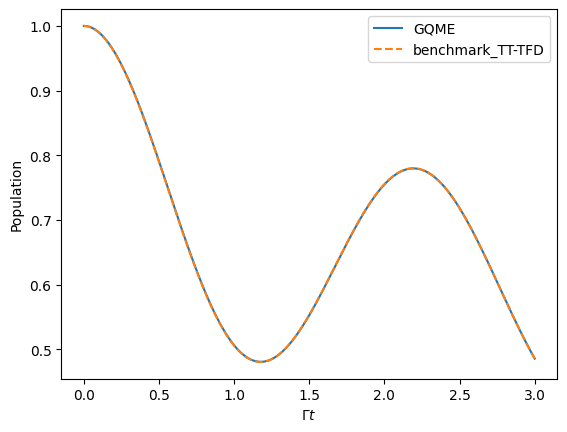

In [19]:
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
timeVec, sigma = wr.read_operator_array("GQME_Output/Sigma_")

#plot
plt.plot(timeVec, sigma[:,0], label='GQME')
plt.plot(timeVec, sigma_tt_tfd[:,0] ,'--', label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$')
plt.ylabel('Population')
plt.legend()